# Spatial CV

Apply and compare:

- random CV,
- spatial CV,
- geo-attribute based CV.

We will study 2 geospatial datasets:

- domestic violence,
- obesity.


### Domestic violence

Use a random forest regressor to predict domestic violence based on socioeconomic and demographic variables from the city of Chicago, USA.

- The global Moran’s I of the domestic violence data is 0.648 (p<0.001)
- The independent variables are 19 socioeconomic and demographic variables in five categories:

  (1) race and ethnicity,
  (2) age,
  (3) social disadvantage level,
  (4) residential instability, and
  (5) urbanicity.

#### Data partition

- Random CV: traditional 10-fold CV by randomly splitting all CBGs (Census Bloc Groups) into 10 subsets.
- Clustering-based spatial CV:  k-means clustering to split the whole data set into 10 clusters (i.e., k = 10).
- Geo-attribute-based spatial CV: Using a geo-attribute of community names in Chicago, we split the data (2,146 CBGs) to 96 communities.

Adapted from the [original version](https://github.com/geoai-lab/spatialCV).

Sun, K., Hu, Y., Lakhanpal, G., & Zhou, R.Z. (2023): Spatial cross-validation for GeoAI, In: S. Gao, Y. Hu, and W. Li (Eds), Handbook of Geospatial Artificial Intelligence, Taylor & Francis Group. [link](https://www.taylorfrancis.com/books/edit/10.1201/9781003308423)

In [1]:
# Packages
import pandas as pd
import numpy as np
import geopandas as gpd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

import statsmodels.api as sm
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib as mpl

## Domestic Violence Dataset

In [2]:
# load the dataset for domestic violence prediction

df_DV = pd.read_csv("./Data/DV/DV.csv")
df_DV[["CensusBloc"]] = df_DV[["CensusBloc"]].astype(str)
y = df_DV["DV rate"]
df_DV.shape

(2146, 23)

In [3]:
# Load the CBG shapefile of Chicago

boundary = gpd.read_file("./Data/DV/chicago_cbg.shp")

In [4]:
# Create the geodataframe for the data

gdf_DV = gpd.GeoDataFrame(df_DV, geometry=gpd.points_from_xy(df_DV['Lonpro'], df_DV['Latpro']))

In [5]:
# Define the predictors

using_columns = ['population density', '% White', '% Ame Indi and AK Native', '% Asian', '% Nati Hawa and Paci Island', 
                 '% Hispanic', '% age 18-29', '% age 30-39', '% age 40-49', '% age 50-59', '% age >60', 'med income', 
                 '% unemployment', '% female hh', '% <highschool', '% security inc', '% assistant inc', '% renter hh', 
                 '% stay >=5yrs']
num_features = len(using_columns)
num_features

19

In [6]:
# Standardization function

def standarize_data(data, stats):
    return (data - stats['mean'])/stats['std']

## Random CV

In [7]:
y_predict = []
y_true = []

ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Train model on folds
for train_index, test_index in ten_fold.split(df_DV):
    print("fold:", str(i))

    # Create training/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model 
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False)
    rf.fit(X_scaled_train, y_train)
    
    # Generate predictions using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()
    
    i = i + 1

# Calculate and display RMSE and R2 scores
rmse_rcv = root_mean_squared_error(y_true, y_predict)
r2_rcv = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse_rcv,4)), "r2: " + str(round(r2_rcv,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
rmse: 8.92 r2: 0.597


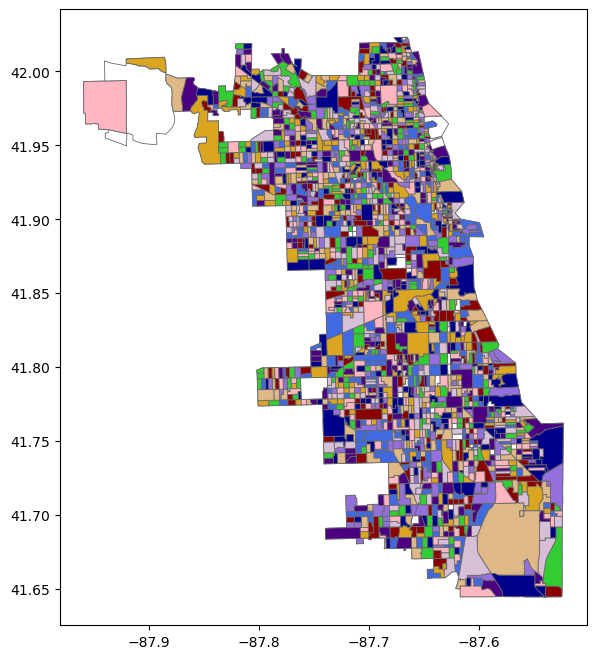

In [8]:
# Making a figure for random CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']

# Populate figure with data
i=0
for train_index, test_index in ten_fold.split(df_DV):  
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save figure
#plt.savefig('../Data/DV/Figs/random.png', dpi=300)
plt.show()

## Clustering-based spatial CV

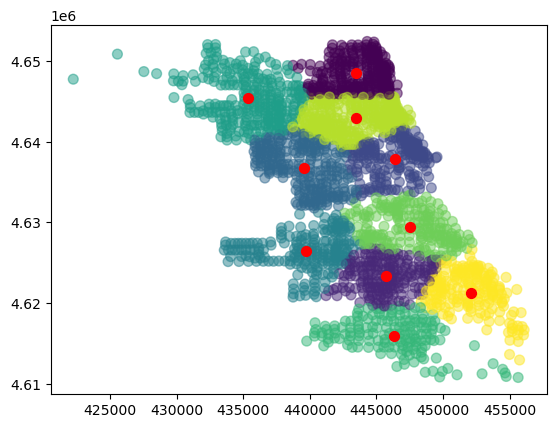

In [9]:
# Split the data based on their coordinates using k-means clustering algorithm

# Get coordinates
coordinates = df_DV[['Lonpro','Latpro']]

# Cluser data using K-means
kmeans = KMeans(n_clusters=10, random_state=42).fit(coordinates)
centroids = kmeans.cluster_centers_

# Visualize K-means clustering
plt.scatter(coordinates['Lonpro'], coordinates['Latpro'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [10]:
# label the cluster index for each record. 

df_DV_cluster = df_DV.copy()
df_DV_cluster["cluster"] = kmeans.labels_.tolist()
df_DV_cluster["cluster"].value_counts()

cluster
8    286
5    271
3    245
0    237
4    200
7    195
2    190
1    184
9    181
6    157
Name: count, dtype: int64

In [11]:
y_predict = []
y_true = []

group_index = df_DV_cluster['cluster'].values

group_kfold = GroupKFold(n_splits=10)

i = 1

# Train and predict on clusters
for train_index, test_index in group_kfold.split(df_DV_cluster, y, group_index):
    print("fold:", str(i))

    # Create train/test splits
    X_train_all, X_test_all = df_DV_cluster.iloc[train_index], df_DV_cluster.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest models
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False)
    rf.fit(X_scaled_train, y_train)
    
    # Generate predictions using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()    
    
    i = i + 1

# Calculate and display RMSE & R2 
rmse_km = root_mean_squared_error(y_true, y_predict)
r2_km = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse_km,4)), "r2: " + str(round(r2_km,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
rmse: 9.4922 r2: 0.5437


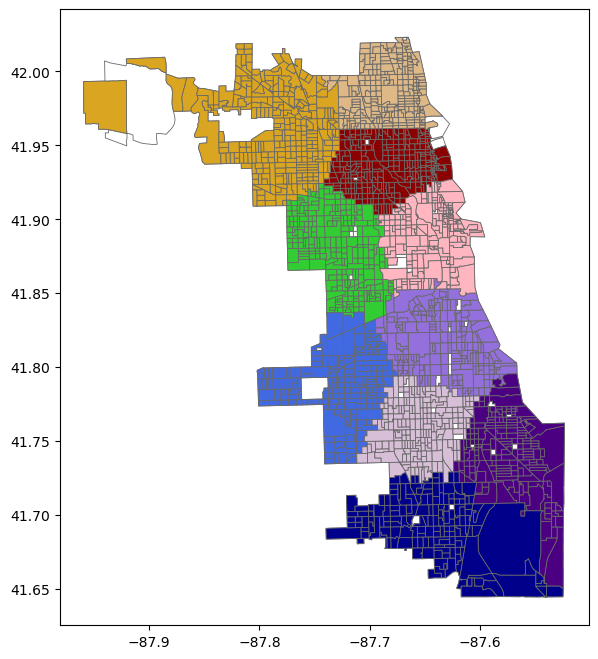

In [12]:
# Making a figure for cluster based spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure
i=0
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']
for train_index, test_index in group_kfold.split(df_DV_cluster, y, group_index):  
    test_index = df_DV_cluster.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and show figure
#plt.savefig('../Data/DV/Figs/cluster.png', dpi=300)
plt.show()

## Geo-attribute-based spatial CV

In [13]:
# Load the CBG-level and neighborhoods-level data of Chicago 

gdf_cbg = gpd.read_file("./Data/DV/chicago_cbg.shp")
gdf_cbg = gdf_cbg.to_crs('epsg:26916')

gdf_neigh = gpd.read_file("./Data/DV/chicago_neighborhoods.shp")
gdf_neigh = gdf_neigh.to_crs('epsg:26916')

In [14]:
# Determine which neighborhood each CBG is located in based on the intersection area.

fid_list = []

# Search through CBGs
for index1, row1 in gdf_cbg.iterrows():
    geometry1 = row1["geometry"]
    percentage = 0
    fid = 0
    for index2, row2 in gdf_neigh.iterrows():
        geometry2 = row2["geometry"]
        fid_temp = index2
        perc_temp = (geometry1.intersection(geometry2).area/geometry1.area)*100
        if perc_temp > percentage:
            percentage = perc_temp
            fid = fid_temp
    fid_list.append(fid)

# Store unique CBGs
gdf_cbg["neigh_id"] = fid_list
gdf_cbg.neigh_id.nunique()

96

In [15]:
# Label the neighborhood index of each CBG

df_DV_block = df_DV.merge(gdf_cbg[['CensusBloc','neigh_id']], how='left', left_on="CensusBloc", right_on="CensusBloc")
df_DV_block.neigh_id.nunique()

96

In [16]:
y_predict = []
y_true = []

block = df_DV_block['neigh_id'].values
group_kfold = GroupKFold(n_splits=96)

i = 1

# Train and predict on identified neighborhoods 
for train_index, test_index in group_kfold.split(df_DV_block, y, block):
    print("fold:", str(i))

    # Create train/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False) 
    rf.fit(X_scaled_train, y_train)
    
    # Predict using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()    
        
    i = i + 1

# Calculate and display RMSE & R2
rmse_geo = root_mean_squared_error(y_true, y_predict)
r2_geo   = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse_geo,4)), "r2: " + str(round(r2_geo,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
fold: 11
fold: 12
fold: 13
fold: 14
fold: 15
fold: 16
fold: 17
fold: 18
fold: 19
fold: 20
fold: 21
fold: 22
fold: 23
fold: 24
fold: 25
fold: 26
fold: 27
fold: 28
fold: 29
fold: 30
fold: 31
fold: 32
fold: 33
fold: 34
fold: 35
fold: 36
fold: 37
fold: 38
fold: 39
fold: 40
fold: 41
fold: 42
fold: 43
fold: 44
fold: 45
fold: 46
fold: 47
fold: 48
fold: 49
fold: 50
fold: 51
fold: 52
fold: 53
fold: 54
fold: 55
fold: 56
fold: 57
fold: 58
fold: 59
fold: 60
fold: 61
fold: 62
fold: 63
fold: 64
fold: 65
fold: 66
fold: 67
fold: 68
fold: 69
fold: 70
fold: 71
fold: 72
fold: 73
fold: 74
fold: 75
fold: 76
fold: 77
fold: 78
fold: 79
fold: 80
fold: 81
fold: 82
fold: 83
fold: 84
fold: 85
fold: 86
fold: 87
fold: 88
fold: 89
fold: 90
fold: 91
fold: 92
fold: 93
fold: 94
fold: 95
fold: 96
rmse: 9.2484 r2: 0.5668


In [17]:
# Create a list containg a specific number of colors randomly.

import colorsys
import random
 
def get_n_hls_colors(num):
    hls_colors = []
    i = 0
    step = 360.0 / num
    while i < 360:
        h = i
        s = 90 + random.random() * 10
        l = 50 + random.random() * 10
        _hlsc = [h / 360.0, l / 100.0, s / 100.0]
        hls_colors.append(_hlsc)
        i += step
 
    return hls_colors

def ncolors(num):
    rgb_colors = []
    if num < 1:
        return rgb_colors
    hls_colors = get_n_hls_colors(num)
    for hlsc in hls_colors:
        _r, _g, _b = colorsys.hls_to_rgb(hlsc[0], hlsc[1], hlsc[2])
        r, g, b = [int(x * 255.0) for x in (_r, _g, _b)]
        rgb_colors.append([r/255, g/255, b/255])
 
    return rgb_colors

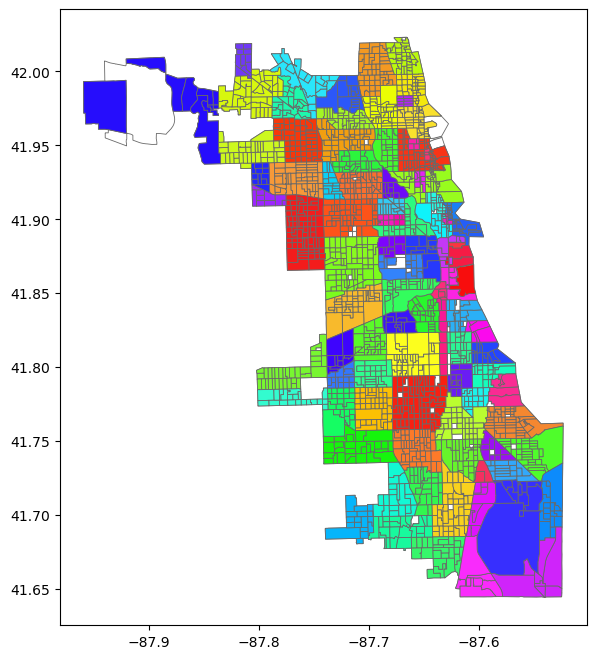

In [18]:
# Making a figure for geo-attribute based spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure with data
i = 0
color_list = ncolors(95)
for train_index, test_index in group_kfold.split(df_DV_block, y, block):  
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
#plt.savefig('../Data/DV/Figs/geo.png', dpi=300)
plt.show()

## Conclusions



In [23]:
import pandas as pd

# Define the results for each method
results = {
    "Method": ["Random CV", "Cluster CV", "Geo-based CV"],
    "RMSE": [rmse_rcv, rmse_km, rmse_geo],
    "R²": [r2_rcv, r2_km, r2_geo]
}

# Create a DataFrame
df = pd.DataFrame(results)

# Print the table
#print(df.to_string(index=False))
df

,Method,RMSE,R²
0,Random CV,8.919960,0.597036
1,Cluster CV,9.492222,0.543673
2,Geo-based CV,9.248378,0.566817


1. Different performance scores are obtained when different CV methods are used for splitting the data.
2. The performance scores by themselves do not suggest which CV method should be ideally used; instead we should choose the CV method that best mimics the real application scenario of the trained model.
3. Overall, the results in the Table show that the highest performance scores are obtained using random CV, while lower performance scores are obtained using the two spatial CV methods.
4. The highest performance scores from random CV are likely due to the many spatially adjacent training and validation data instances generated by random CV, which allows the RF model to “peek” into nearby validation data during the training process.
5. The performance scores obtained based on random CV are about 5% - 11% higher (i.e. overestimated) than those obtained via the spatial CV methods, but are not radically different in this example.
6. This suggests that the scores of random CV in this example  could be reliable, but probably present a slight overestimate of the model performance, even though spatial CV should ideally be used.